# Generating Robot Names
## Using a RNN in Pytorch
In this notebook, we'll create a RNN language model that learns to generate new robot names from on existing robot names corpus from the past century - everything from movies, games and TV.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import random
import unidecode
import numpy as np
from tqdm import tqdm

In [2]:
## File path
file_name = "./data/names/robot-names.txt"

In [3]:
EOS = '\n'
all_characters = string.ascii_letters + " .,;'-0123456789" + EOS
n_letters = len(all_characters) # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

# Read a file and split into lines
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Build the lines file
lines = open(file_name, encoding='utf-8').read().strip().split('\n')

file, file_len = read_file(file_name)
all_names = [unicodeToAscii(line) for line in lines]

n_names = len(all_names)

if n_names == 0:
    raise RuntimeError('Data not found.')

print('# names: {}, # chars: {}'.format(n_names, n_letters))
print("\n...")
for i in range(10):
    print("{}".format(all_names[np.random.randint(n_names)]))

# names: 702, # chars: 69

...
XJ-9 Wakeman
SHROUD
Gallegher
Welder
Madame Adolphine
HCR-328
NANCY-MI847J
Hermes
Chuck the Robot
Dr. Kahl's Robot


#### Data processing
Let's implement some functions for aggegating and processing the data before assigning it to Tensor objects.

#### Random sampling
Here we implement random sampling for use in training.  Without random sampling, a powerful enough network is able to memorise the sequence of names and recursively output the given dataset.

In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

### Building the basic unit

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

#    def forward2(self, input, hidden):
#        encoded = self.encoder(input.view(1, -1))
#        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
#        output = self.decoder(output.view(1, -1))
#        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

### Defining targets

In [6]:
# String to tensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

In [7]:
# Make input, and target tensors from a random line
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

### Training the network

In [8]:
criterion = nn.NLLLoss()

print_every = 60
n_epochs = 2400
chunk_len = 250
batch_size = 32
learning_rate = 0.0001
n_layers = 4
hidden_size = 256

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

save_filename = "Robomoniker-model-GRU.pt"

def save():
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

### Optimisation and loss

In [9]:
import time
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
decoder = CharRNN(
    n_letters,
    hidden_size,
    n_letters,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Generator

In [11]:
max_length = 20

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        top_i = max(0, min(top_i, len(all_characters)-1))
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [12]:
start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        all_losses.append(loss)

        if epoch % print_every == 0:
            print('[%s (%d %d%%) loss = %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            rand_char = random.choice(all_characters)
            print(generate(decoder, prime_str=rand_char, predict_len=100), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()

Training for 4000 epochs...


  1%|▊                                                                             | 39/4000 [01:49<3:11:48,  2.91s/it]

 52s (40 1%) loss = 3.5822]
6oGnI5kRBat1wJnDean 
knS RGr3-arba- eoeoaItAiNagto
lZotoeeoYtho
iaW
e 
a
TlPn etinoJ
SLr
 dooo
o
'sDO 



  2%|█▌                                                                            | 79/4000 [04:08<4:24:11,  4.04s/it]

 13s (80 2%) loss = 3.5316]
B0JCXYhbt-dCM- -olraGnaS sr
roaiok
teolc
lanaeneoOseas
rleoateielbt dtFUoiet-snhT
lOplal
naagzcKkoBtl 



  3%|██▎                                                                          | 119/4000 [06:31<5:18:49,  4.93s/it]

 35s (120 3%) loss = 3.4864]

yg NMr
alpoGt
e-e
yDMaUnt
rnlWod rtei
Claa
KMaKerACSbI
otmtnaSi
t
raeDnmu 
ltaEok ipoccrulso
hOoTi a 



  4%|███                                                                          | 159/4000 [09:24<5:40:55,  5.33s/it]

 28s (160 4%) loss = 3.2480]
B-ZV0
BUolrs
RooBe
oa1
rtla nhatrbKro
C7erme
ACGkle oto
oeirC cSrtteoo
Coebr
Rbo
rarnngdleesnren erez 



  5%|███▊                                                                         | 199/4000 [11:41<3:43:21,  3.53s/it]

 45s (200 5%) loss = 2.9313]
1;'Ln
Jernn LME pahoaa
Ee
xeia E
SeietT Roe
INlinateu
Crob
Mrro
Gbotr
Teo
Hianr
luo
Roon slok
Avio
eh 



  6%|████▌                                                                        | 239/4000 [13:57<3:34:49,  3.43s/it]

 0s (240 6%) loss = 2.7278]
n01
Bmamox
Robon
Noc2t
Frae Kilsia
Iasrbott
Trina Siacnc Tartan
Ceorbon
Roeny
VRo
XYo
Hoi Roo1d
Caare 



  7%|█████▎                                                                       | 279/4000 [16:38<3:01:48,  2.93s/it]

 41s (280 7%) loss = 2.6837]
o
Tin
Moro
Supuren
Bary
Gagirad
Omastarco
Jaw
4lirt
Robot Rott Arcer
Misi
Lld--b2
Mora
Mabot
Ank
avag 



  8%|██████▏                                                                      | 319/4000 [18:53<3:06:40,  3.04s/it]

 56s (320 8%) loss = 2.5345]
N88V
Semy
Jescor
Mancreta
Bimca Pankiclror
FmoWal Pritan Gunebot
Th Robobon
Acitobo Robo
Graton
RoboC 



  9%|██████▉                                                                      | 359/4000 [21:17<3:55:24,  3.88s/it]

 21s (360 9%) loss = 2.4845]
hScmere
Merkia
Kpas.
Cralkor
Piisk
oHYKbot
Robot
Phane Tace Cep Illo Zanx
Janx q-P4
Merr Mand
Fsian
N 



 10%|███████▋                                                                     | 399/4000 [23:43<4:13:52,  4.23s/it]

 46s (400 10%) loss = 2.3857]
h Dan Wer
Gragh
Secne Teet
Adlal
Lfilean
Dlart
Sernettron
Chard
Tlobot
Taranun
Ticafhronis
Kranilemor 



 11%|████████▍                                                                    | 439/4000 [26:23<3:37:47,  3.67s/it]

 27s (440 11%) loss = 2.2859]
G0d
Tonbot
Metatato
Vh-04 Oegh Servebo
Nohne Knectt
Zea Robot
Roiser
Jemerador
Ibe-Robot
Meplera
RoGo 



 12%|█████████▏                                                                   | 479/4000 [28:34<3:38:53,  3.73s/it]

 37s (480 12%) loss = 2.2114]
lDlor Brids
Sache
Robot
Yarne Robot
Nolbot
Hanke
Mater
Jachsver Probot
Barknel Mere
1bot Bot Magent
B 



 13%|█████████▉                                                                   | 519/4000 [30:37<2:42:52,  2.81s/it]

 41s (520 13%) loss = 2.1372]
elcanocen
Lincy 1
Bot
Warger era 1N
Tor
Hurh
Bot
Ceictor
Nopbot
Marsa Blinnk Hechi Mama
Zha
Imic Andr 



 14%|██████████▊                                                                  | 559/4000 [32:46<2:39:34,  2.78s/it]

 49s (560 14%) loss = 2.0063]
Visco
Anna
Hundernes
Oh-R
Slew
Julanoro
Zero
Zero
Tero Robot
Tobot
Ciner
Robot Ifbot
Comper
Col-K-O
T 



 15%|███████████▌                                                                 | 599/4000 [35:19<2:48:37,  2.97s/it]

 24s (600 15%) loss = 2.0454]
Os
Romid Crurnk
The Otasd
Rude Anper
Serlige
Karier Hacsretron
Chiljor Ame Drone
Pranene Wester
Medan 



 16%|████████████▎                                                                | 639/4000 [37:34<3:29:56,  3.75s/it]

 37s (640 16%) loss = 1.9202]
SK
Tane
Madeced
Robo-Watron
Nuutor
CANO
Su-Ne
Salan
Macian
Runder Mant Vinik Robot
Meeducton
Probo-Ch 



 17%|█████████████                                                                | 679/4000 [39:52<2:58:47,  3.23s/it]

 55s (680 17%) loss = 1.8026]
jzrisgiro
Ode Robot
Olan
Ash Oris
Friul Dol Robot
KIJin
Getala
Iros
Medal
Teghtron
Daskate
Fradian
Ch 



 18%|█████████████▊                                                               | 719/4000 [42:08<3:13:07,  3.53s/it]

 11s (720 18%) loss = 1.7870]
X-00B
2000
VAR-9
Siptor
Roboy
Conic
Mix
Bronne
Olad Andiner
Sini
Ila
Hulas
Or Sinder
Itimic
Frian
Fus 



 19%|██████████████▌                                                              | 759/4000 [44:15<3:40:42,  4.09s/it]

 18s (760 19%) loss = 1.7011]
vara Arhina Kids
Maced
The Robot
41
SCK-R67
B-3
Bym
Dr. Mawifa ter Vina
Tulobot
Ormene Sralight Robot 



 20%|███████████████▍                                                             | 799/4000 [46:38<3:02:39,  3.42s/it]

 41s (800 20%) loss = 1.6344]
varkher Garmy Robot
Cory Bom Medass
CFifdbot
Comman
Esector Cobot
CCOX-73
Poridic
CEM
AD-20Z
Lilty Ze 



 21%|████████████████▏                                                            | 839/4000 [48:54<2:28:37,  2.82s/it]

 57s (840 21%) loss = 1.6481]
varl
Hof Robot
Sfache
Slandy Race
Rones
Nutbot
Ilpan
Shatran Man
Gusse Nady
Perboo
qelter Mang Appima 



 22%|████████████████▉                                                            | 879/4000 [51:11<2:42:20,  3.12s/it]

 13s (880 22%) loss = 1.5761]
'crox the Trecter
Yoe Starkher Sesx
Tenlopkat
The Macha
Marger
Ted Zide X
X-R
Tim
Dasinuger
Meal Tunk 



 23%|█████████████████▋                                                           | 919/4000 [53:10<2:36:21,  3.04s/it]

 12s (920 23%) loss = 1.4364]
ET
Ast 25
Robo-Randy
Tink
Fries
Conder
Lenge-No
Avic Man
Daven
Chice La
Gron
Marknetron
Kirster Cforv 



 24%|██████████████████▍                                                          | 959/4000 [55:14<2:58:53,  3.53s/it]

 18s (960 24%) loss = 1.4400]
Ukhsrian
Prote Adnea Huster
Emier Tut
Dace L1 EVE
Chima
Gort
Kallbot
Ix-Ma
Lister
Noober
Zane Dobot
F 



 25%|███████████████████▏                                                         | 999/4000 [57:15<2:17:41,  2.75s/it]

 19s (1000 25%) loss = 1.3250]
fmabot
Nuy
Sarchine
the Nags
Tret Tot
ED Trobot
Alsha
Indetsi
Malkic
Ganink ome
Smamoa Robot Robot on 



 26%|███████████████████▋                                                        | 1039/4000 [59:20<2:59:42,  3.64s/it]

 23s (1040 26%) loss = 1.3145]
A'gro Morton
Maran
Anpart 100
Dr. Bricker
Shis
Mids Robot
Conk Iro
Comila
Modarag
Anly Alisa
Bom
Hurl 



 27%|███████████████████▉                                                      | 1079/4000 [1:01:22<2:13:07,  2.73s/it]

 25s (1080 27%) loss = 1.2369]
-NBo
Azia
Hurte
Drboby
Jeanbot
Marwbera Charge
Hamina
Manher 100
T-10
Svid
Detate X
Robot I0D
Jean
To 



 28%|████████████████████▋                                                     | 1119/4000 [1:03:24<2:35:26,  3.24s/it]

 26s (1120 28%) loss = 1.2309]
.
Serlin Robot
Jeent
The HAAE7
T-1003
C-X-100
Spom
Mustro
Loshis
V3
Irup Ivo
Iutono
Atomic Pred
Prict 



 29%|█████████████████████▍                                                    | 1159/4000 [1:05:25<2:10:51,  2.76s/it]

 28s (1160 28%) loss = 1.1678]
lolt
Sachbot
Macructot
Turstor
Lore
Roboto
Droidd
Maphius
Tid
Kurtbot
Fubot Vcreen
Krihe Lan
Clidmen
 



 30%|██████████████████████▏                                                   | 1199/4000 [1:07:23<2:06:46,  2.72s/it]

 27s (1200 30%) loss = 1.0503]
nreganid
Leck Manpord
The tha Scht Robot
Atorbot
Ash Dro
Kisk Toon
Orkis
Hurty
OtonR1
Johnny Biya
Stu 



 31%|██████████████████████▉                                                   | 1239/4000 [1:09:35<2:12:41,  2.88s/it]

 37s (1240 31%) loss = 1.0378]
Sm
Gacod
Gallegha Qoondor
Hatvewtructo
Dator
Rumdel Mine
Nindroid
Nan Tors
Number Pin
Wel EWuamier
Ro 



 32%|███████████████████████▋                                                  | 1279/4000 [1:11:41<2:12:20,  2.92s/it]

 44s (1280 32%) loss = 0.9665]
Born
Har Ganisnen
Daliciuretor
Berson
Wink Ara
Hafher
Moron Tors
Number Avatrin
Anigator
Space Gero
B 



 33%|████████████████████████▍                                                 | 1319/4000 [1:13:52<2:20:34,  3.15s/it]

 55s (1320 33%) loss = 0.9199]
'nlinker
Chei
Nuutero
Sectol Troopertron
Guardbot Bot
Dadac Ama Xo
Briemon
Pring Mavega
Neck Visie
Cl 



 34%|█████████████████████████▏                                                | 1359/4000 [1:16:06<2:27:26,  3.35s/it]

 9s (1360 34%) loss = 0.8440]
Zerton
David
Robo-Na
Her Kiom
Manders
Zero Adoslli
Chip
Robotbobo
Milly 30
Maya Sache Robot
Johgce Jo 



 35%|█████████████████████████▉                                                | 1399/4000 [1:18:08<2:19:32,  3.22s/it]

 10s (1400 35%) loss = 0.8156]
,ularien
Chip
Tistar Echanhancudor
Tarkmine
Heptono
Lilti Robo
Oight
The Robot
Karll Kowber Robot
Aza 



 36%|██████████████████████████▌                                               | 1439/4000 [1:20:14<2:06:16,  2.96s/it]

 17s (1440 36%) loss = 0.7543]
itren Emalter
Molone
Maving Mathi
Larry 2000
Robot Silyroi
Ruber
IAdad
Kapkida
Hurly
Tkoe
Sashis
STo
 



 37%|███████████████████████████▎                                              | 1479/4000 [1:22:19<2:21:02,  3.36s/it]

 22s (1480 37%) loss = 0.7154]
Mlrator
Robot Thorsnoid
Hummano
Hive
Kevin
Marhina
Mega
Guarkgoo
Kuran Charch Ava
Farien
Hanator
Vaff 



 38%|████████████████████████████                                              | 1519/4000 [1:24:32<2:22:25,  3.44s/it]

 35s (1520 38%) loss = 0.6618]
Uclrenter Ameso
HO1000
Broni
Atulaso
CD-88
Clicker
All Fanger
Dech Robot
Franhepter
Robo-Lawyer
Robo- 



 39%|████████████████████████████▊                                             | 1559/4000 [1:26:36<2:03:39,  3.04s/it]

 40s (1560 39%) loss = 0.6294]
Q;erlyron
Ruth Robot
Cumanors
Ruby Congo
Tom Sum
Alpha Kisk Tachikon
Tive
Jeanky Zeid
Adili
Xobot
TNi 



 40%|█████████████████████████████▌                                            | 1599/4000 [1:28:44<2:06:53,  3.17s/it]

 46s (1600 40%) loss = 0.6076]
Qerron Partneud Trid Robot
Mapce Neamietox
Vai
Harkness
Ammousreizectronic
A4-OOOO
TAR-93
Dr. Ashlatt 



 41%|██████████████████████████████▎                                           | 1639/4000 [1:30:48<1:55:45,  2.94s/it]

 51s (1640 41%) loss = 0.5621]
 Klid
Kigty
Bont
Mandy Incun
The Cronper Mank
Kurtbot
BBbot
Codssirad Hip Ashatrina
Dag
Kaimon Tisd
A 



 42%|███████████████████████████████                                           | 1679/4000 [1:33:15<2:24:51,  3.74s/it]

 21s (1680 42%) loss = 0.5847]
Tsrector Kalmix Evatiina
Lindroid
Mynhander
Andy Man
Goass
Lomuger
Isal Micker
Bathbot
Partron Robot
 



 43%|███████████████████████████████▊                                          | 1719/4000 [1:35:28<1:52:28,  2.96s/it]

 31s (1720 43%) loss = 0.5339]
Robot
Krackenstein
King
Mechatron
Vister Rotone
CANpx
Afile
Dedistor
Robot To
Druncy Zenyer
Cury 5
Di 



 44%|████████████████████████████████▌                                         | 1759/4000 [1:37:26<2:04:52,  3.34s/it]

 31s (1760 44%) loss = 0.4866]
EQd-E
Gictor
Broby
Proter Al. Mana
Gale Hanhennooderidd
Mildred 7
Nomad Zanator
EIDh
Markgor
Isasa
Le 



 45%|█████████████████████████████████▎                                        | 1799/4000 [1:39:40<1:58:10,  3.22s/it]

 44s (1800 45%) loss = 0.4089]
Szk
Markuro
Nectex Wisi
Alip Termood Tarkkatta
Larro
Chip
Kette
Iano
Aigor the Skernderc
Colis
Frees
 



 46%|██████████████████████████████████                                        | 1839/4000 [1:41:53<2:03:37,  3.43s/it]

 56s (1840 46%) loss = 0.4011]
man
Tors
Berly Brass
Kittiz ID
4O Digutio
H1 Robot
Quardy 5
Ronip Tigh
T-Bot
Serlin
Kuton
Blitz 9
Ro- 



 47%|██████████████████████████████████▊                                       | 1879/4000 [1:43:56<1:58:14,  3.35s/it]

 59s (1880 47%) loss = 0.3833]
ron Haro
Zane Kuod
Automon
Alpha and Edugh Mamor Makivato
Amokonayron
Rakoton
AHAROO
Micke
Light
Wate 



 48%|███████████████████████████████████▌                                      | 1919/4000 [1:46:09<1:44:17,  3.01s/it]

 15s (1920 48%) loss = 0.3701]
id Evet
Alfoid
Tre Hawrr Impact
Jeanbot
Destructbot
Setarakien
Hinu
The Mai
Nubot
Boz
Chii Acassissa
 



 49%|████████████████████████████████████▏                                     | 1959/4000 [1:48:20<1:59:01,  3.50s/it]

 23s (1960 49%) loss = 0.3159]
sz
Hana
Linger
Baktebot
VCOR
Proto-Ape
Idopo
Kfamidy Ses
Azia
Huloma
Gorg
Sallke
Ladian
Tight
Bester  



 50%|████████████████████████████████████▉                                     | 1999/4000 [1:50:29<1:39:19,  2.98s/it]

 32s (2000 50%) loss = 0.3347]
on
Ullysher
Robo-Ractor Robot Zero
Peedo Huwisa
Jack rabot
Jacks
SAR-880
1-1
Divemmabot
Bultamon
The  



 51%|█████████████████████████████████████▋                                    | 2039/4000 [1:52:37<1:48:02,  3.31s/it]

 40s (2040 51%) loss = 0.2717]
nny
Dod
Kalfperdirad
Mecha Kolbot
3JQ4
Servbot
Sackbot
Working Eve
Harina
The Clinker
Jader
Scaramouc 



 52%|██████████████████████████████████████▍                                   | 2079/4000 [1:54:56<1:44:11,  3.25s/it]

 0s (2080 52%) loss = 0.2999]
QEUGRo-2
Bishop
Blitz bot
BO
Porby-2
Olik
Ja'gre
Waeture
Mistite
Robot Shooty Thing
Rotox
Robot Alhor 



 53%|███████████████████████████████████████▏                                  | 2119/4000 [1:57:04<1:40:29,  3.21s/it]

 7s (2120 53%) loss = 0.2624]
mismo
Robot 67 Bright on
Huti
Medibot
Bary
Tony
Jane Humanoi
Karunk Tacha
Hek
Hartron
Valerie 2000
Ma 



 54%|███████████████████████████████████████▉                                  | 2159/4000 [1:59:19<2:21:55,  4.63s/it]

 23s (2160 54%) loss = 0.2551]
IcOZent
ALdroid
Aldradossu
Adifidy
Ormeco
Zemoa
Ispas
Metal Alina Ada
Karving
Teel
Zero unfer
Anme La 



 55%|████████████████████████████████████████▋                                 | 2199/4000 [2:01:34<1:28:01,  2.93s/it]

 38s (2200 55%) loss = 0.2208]
oqhernys
Mochmaz
Chine
Rudbot
Dr. Roger Fick
Blitz
Brony
tho Hive
Robo-Lawyer
Robo-Pacy
Scrutberbot
S 



 56%|█████████████████████████████████████████▍                                | 2239/4000 [2:03:35<1:25:43,  2.92s/it]

 40s (2240 56%) loss = 0.2082]
jerlly
Cynak Tachinator
Cylon
Number Eight
Galen Two
Lacter John
Zed
K1
Rooboto
Wood-Zace Number Sing 



 57%|██████████████████████████████████████████▏                               | 2279/4000 [2:05:42<1:29:31,  3.12s/it]

 47s (2280 56%) loss = 0.2303]
clety 2400
1-Rowberi
Autonic SARo
Sack Tic
Al Humano
Tilly
Chip
Coach Gridiron
Clevetron
Cosbytron Vi 



 58%|██████████████████████████████████████████▉                               | 2319/4000 [2:07:46<1:33:01,  3.32s/it]

 49s (2320 57%) loss = 0.1901]
wo-Zero
Sektor
Smoke
Sectox-69
Nany
Orniaz
Autobot
Ian
Bovarso
Dudy
Cubot
Robo-Ape
Robo-Baby
Robot
Do 



 59%|███████████████████████████████████████████▋                              | 2359/4000 [2:09:50<1:28:11,  3.22s/it]

 52s (2360 59%) loss = 0.1937]
5
Beyshono
Chachamariet
Ango
Deramon
Mariina Shufte Elima
Mettaton
K1-B0
Spong Ava Evasio
Farl Gideo
 



 60%|████████████████████████████████████████████▍                             | 2399/4000 [2:11:50<1:20:07,  3.00s/it]

 53s (2400 60%) loss = 0.1761]
Wertbot 20000
Orisa
Selli
Lervon
Cylon
Number One
Number Presk
Androzani
Karfelan
Drathro
L1 Robot
So 



 61%|█████████████████████████████████████████████                             | 2439/4000 [2:13:50<1:23:44,  3.22s/it]

 53s (2440 61%) loss = 0.1694]
stron Partner Robot
GUADM
Astro-Bot
Noodsdar
Kilty Zes
Dod-Zerox
Bossor
Nano
Link Joa
Nano
Manhuntes
 



 62%|█████████████████████████████████████████████▊                            | 2479/4000 [2:15:56<1:17:23,  3.05s/it]

 59s (2480 62%) loss = 0.1403]
.
Zeroid
Robotboy
Ben 10
Slix Vigma
SAM
Fallbot
Lirl
Woo-Tace
Rotox
Barbot
Tik Humano
Tiptine
Number  



 63%|██████████████████████████████████████████████▌                           | 2519/4000 [2:18:00<1:11:42,  2.90s/it]

 4s (2520 63%) loss = 0.1476]
Yornder
Haaghortro 9000
Cybot
Sackbot
Working Joe
Industrial Joe
Ghost
Skell
Minadrie
Dr. Lazaar
Tari 



 64%|███████████████████████████████████████████████▎                          | 2559/4000 [2:20:08<1:13:59,  3.08s/it]

 11s (2560 64%) loss = 0.1412]
Warther
CARR
Diger
Balpelder
Dradla
Rapyylon
Guardian of the Status
Kurty
Dr. Vacack
Android 8
Dr. Ge 



 65%|████████████████████████████████████████████████                          | 2599/4000 [2:22:13<1:09:24,  2.97s/it]

 15s (2600 65%) loss = 0.1322]
La
K-XO
STX-3
T-Bobt
Cobot So-Bot
Go-bot
Voltron
Roboto
Voice
Assos
K1-BO
Sillypesd Angor
Evet om Alp 



 66%|████████████████████████████████████████████████▊                         | 2639/4000 [2:24:25<1:35:17,  4.20s/it]

 28s (2640 66%) loss = 0.1370]
7
Sled Aldrian
Cwian
The Vai
Mecker
Black Lion
Blip
Blitz bot
BDot
Batts Robot
ChuLXa
Kimy
Sdusts
Avi 



 67%|█████████████████████████████████████████████████▌                        | 2679/4000 [2:26:30<1:04:38,  2.94s/it]

 33s (2680 67%) loss = 0.1234]
pher Evatar of the Guardian
Osirian Visiu 5
Welder
Xony Test
Tama
Woodbot
Serling
Viral
Cyber Shredde 



 68%|██████████████████████████████████████████████████▎                       | 2719/4000 [2:28:35<1:23:27,  3.91s/it]

 38s (2720 68%) loss = 0.1240]
dy
Dr. Gero
Beetlebot
Bossbot
Rubert
The Vacunator
Ezekiel
X-bot
Ping
Pintsize
Clango Cyclotron
Stell 



 69%|███████████████████████████████████████████████████                       | 2759/4000 [2:30:41<1:02:14,  3.01s/it]

 45s (2760 69%) loss = 0.1205]
YEdt
2D0
T-Bob
Bionic Six
Julian Tainer
Tenaya 4
R-Do
Android Al Avatron
Seers of the Oracli
Orliz
Ch 



 70%|███████████████████████████████████████████████████▊                      | 2799/4000 [2:32:43<1:02:17,  3.11s/it]

 45s (2800 70%) loss = 0.1289]
Zero 2000
Evie the Robot
Grindertron
Ken Cne Ham Enhanced Secret Enforcer
Dight
Blink-Ron
Ruckt
Brobo 



 71%|████████████████████████████████████████████████████▌                     | 2839/4000 [2:34:50<1:01:35,  3.18s/it]

 52s (2840 71%) loss = 0.1320]
7
Brikko-Pach-Robo
Chica
Litri Kuso
Zenyatta
Tekhartha Mondatta
Chefbot 9000
Dr. Kahl's Robot
Omnic
G 



 72%|██████████████████████████████████████████████████████▋                     | 2879/4000 [2:36:51<58:32,  3.13s/it]

 55s (2880 72%) loss = 0.1139]
9
S.ot
Adam
Zero
LUX TIZER
Foxy
Chica
Mettaton
K1-9000
T-20
Simo
Clango Cyclotron
Stella 4D
Manager 4 



 73%|███████████████████████████████████████████████████████▍                    | 2919/4000 [2:38:52<54:22,  3.02s/it]

 55s (2920 73%) loss = 0.1013]
60
SEM
Draturi
Anidli
Ara Dakharnus
Marvin
Chip
Roderick
Autobot
Elio
Manders
Selli
Ruembot
Warrenbot 



 74%|████████████████████████████████████████████████████████▏                   | 2959/4000 [2:41:03<54:10,  3.12s/it]

 6s (2960 74%) loss = 0.1001]
A2
Nuty
Ledbot
CDbot
Stockbot
XI-PO
7-S
EDilly
Archie
Lanman Vicimat
Andrea
Ida
Darakomator
Call
X-bo 



 75%|████████████████████████████████████████████████████████▉                   | 2999/4000 [2:43:12<48:50,  2.93s/it]

 15s (3000 75%) loss = 0.1026]
era
Scrapmaster
Scrubberbot
Secretarabot 2500
Space Robot
Krackenstein
Kulyinus
Comber
Ashlotte
Cowbo 



 76%|████████████████████████████████████████████████████████▏                 | 3039/4000 [2:45:25<1:00:10,  3.76s/it]

 28s (3040 76%) loss = 0.0962]
y
Number Three
Number Five
Number Six
Number Seven
Number Eight
Galen Tyrol
Tory Foster
Saul Tigh
Ell 



 77%|████████████████████████████████████████████████████████▉                 | 3079/4000 [2:47:41<1:02:20,  4.06s/it]

 45s (3080 77%) loss = 0.0846]
3
Servo 400
Mace Drone
Mldar
Chine
Cumapon
Krisdnargant of the Guardiamo
Chip
Roderick
Autobot
The Se 



 78%|███████████████████████████████████████████████████████████▎                | 3119/4000 [2:49:54<44:31,  3.03s/it]

 57s (3120 78%) loss = 0.0938]
Zanker
Vanean
Molle Edilite 2000
T-101
Beta
DARYL
Sico
BB
Bishop
Jinx
Spot
RLLa
Listron
The Perimetor 



 79%|████████████████████████████████████████████████████████████                | 3159/4000 [2:52:03<46:39,  3.33s/it]

 7s (3160 79%) loss = 0.1019]
-37
Project 2510
Spongetron
Valerie 23
Mary 25
Azaka
Kamidake
Vanfuceo
Fore
Karumbot
Dacoid
Nodbot
Ze 



 80%|████████████████████████████████████████████████████████████▊               | 3199/4000 [2:54:15<53:25,  4.00s/it]

 20s (3200 80%) loss = 0.0902]
Yomd
Rusty
Satan's Robot
Ian Favon
Number One
Number Two
Number Three
Number Five
Number Shredder
Oct 



 81%|█████████████████████████████████████████████████████████████▌              | 3239/4000 [2:56:20<41:16,  3.25s/it]

 22s (3240 81%) loss = 0.0775]
ver
Eleko
Hapina
Tres
Fallbot
Loganator
Johnny Test
Tama
Woodbot
Serling
Viral
Cyber Shredder
Octus
S 



 82%|██████████████████████████████████████████████████████████████▎             | 3279/4000 [2:58:40<42:34,  3.54s/it]

 42s (3280 82%) loss = 0.0761]
n
Zina Wain
King
Oimiol Indandysson
Tors
Zerone
Mindrien
Specar
Anne Droid
HMX-17a Ilfa
Trin-E
Zu-Zan 



 83%|███████████████████████████████████████████████████████████████             | 3319/4000 [3:01:07<35:22,  3.12s/it]

 10s (3320 83%) loss = 0.0801]
ly
Dr. Ion
Shamus
Cyber Sub-Zatuns
MM7
Mr RING
Death Probe
Questor
Taran
Movellans
K9
Polyphase Avatr 



 84%|███████████████████████████████████████████████████████████████▊            | 3359/4000 [3:03:19<37:11,  3.48s/it]

 23s (3360 84%) loss = 0.0723]
z
Dr. Imaco
Zet
Adimidaton
CHAPPOOR
Bed
Arnus Mapping
Alfie the Robot
Judy
K-Pop
Kitty Ko
Kraken
Krie 



 85%|████████████████████████████████████████████████████████████████▌           | 3399/4000 [3:05:35<36:32,  3.65s/it]

 40s (3400 85%) loss = 0.0819]
wferimod Ace Komoku
Karukie
Nechy Robot
The Servant of the Guardian
Roboto
Vopteco
Specter
XBorg
Yell 



 86%|█████████████████████████████████████████████████████████████████           | 3427/4000 [3:07:10<30:45,  3.22s/it]

Saving before quit...


C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved as Robomoniker-model-GRU.pt


### Training loss history

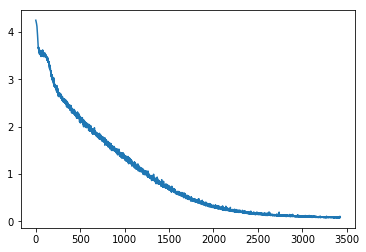

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [15]:
save()

C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved as Robomoniker-model-GRU.pt


In [14]:
decoder = torch.load(save_filename)
primer = string.ascii_letters[np.random.randint(low=26, high=52]
print(generate(decoder, )

SyntaxError: invalid syntax (<ipython-input-14-ce38d2073387>, line 2)